In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import json
import numpy as np
from torch import sigmoid
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def load_file(fileindex,shuffle=True):
    i = fileindex
    df = pd.read_csv(f'data/andrew-data/{i}/raw_data.csv',header=None)
    df = df[[2,3,4]]
    df_np = df.to_numpy()
    with open(f'data/andrew-data/{i}/{i}_data.json','r') as f:
        data = json.load(f)
    puffs = data['puffs']
    windows = []
    labels = []
    for i in range(len(df_np)-100):
        window =  df_np[i:i+100].T.flatten()
        windows.append(window)
        for puff in puffs:
            label = 0
            if(i >= puff['start'] and i < puff['end']):
                label = 1
                break
        labels.append(label)
    windows = np.array(windows)
    labels = np.array(labels)
    X = torch.from_numpy(windows).float().cuda()
    y = torch.from_numpy(labels).reshape(-1,1).float().cuda()
    from torch.utils.data import TensorDataset,DataLoader
    dataloader = DataLoader(TensorDataset(X,y),batch_size=64,shuffle=shuffle)
    return dataloader,df_np

/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataloader,acc = load_file(0,shuffle=True)

In [3]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.d1 = nn.Linear(300,64)
        self.d2 = nn.Linear(64,1)
    def forward(self,x):
        x = self.d1(x)
        x = nn.functional.relu(x)
        x = self.d2(x)
        return x
model = MLP()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())
model.to(device='cuda')

MLP(
  (d1): Linear(in_features=300, out_features=64, bias=True)
  (d2): Linear(in_features=64, out_features=1, bias=True)
)

In [4]:
lossi = []

In [5]:
for epochs in tqdm(range(10)):
    for (X,y) in dataloader:
        logits = model(X)
        loss = criterion(logits,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())

100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


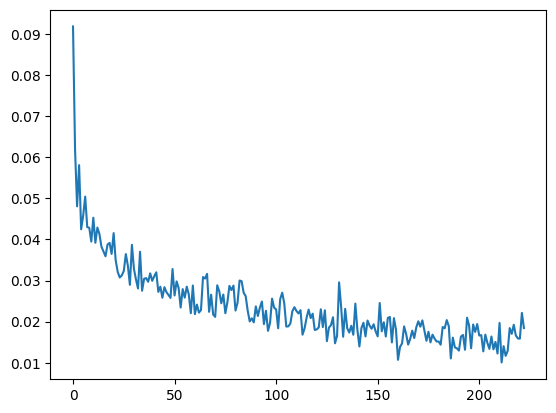

In [7]:
res = 100
plt.plot(torch.tensor(lossi)[:len(lossi)-len(lossi)%res].view(-1,res).mean(1))

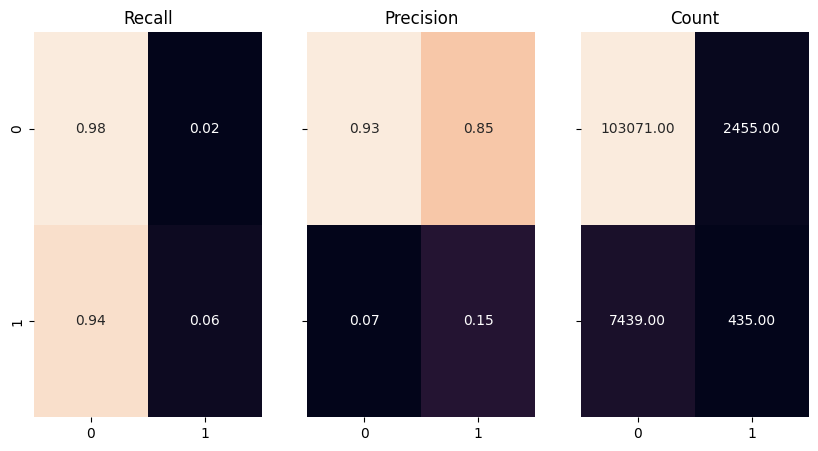

In [10]:
dataloader,acc = load_file(10,shuffle=False)
y_pred = torch.Tensor().cuda()
y_true = torch.Tensor().cuda()

for (X,y) in dataloader:
    X = X.cuda()
    y_true = torch.cat([y_true,y])
    y_pred = torch.cat([y_pred,sigmoid(model(X)).round()])
y_pred = y_pred.detach().cpu()
y_true = y_true.detach().cpu()

fig,axes = plt.subplots(1,3,sharey=True,figsize=(10,5))
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='true'),annot=True,ax=axes[0],cbar=False,fmt='.2f')
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='pred'),annot=True,ax=axes[1],cbar=False,fmt='.2f')
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred),annot=True,ax=axes[2],cbar=False,fmt='.2f')
axes[0].set_title('Recall')
axes[1].set_title('Precision')
axes[2].set_title('Count')
plt.savefig(f'cm.jpg',dpi=200,bbox_inches='tight')

In [11]:
y_pred = torch.Tensor().cuda()
y_true = torch.Tensor().cuda()

for (X,y) in dataloader:
    X = X.cuda()
    y_true = torch.cat([y_true,y])
    y_pred = torch.cat([y_pred,sigmoid(model(X))])
y_pred = y_pred.detach().cpu()
y_true = y_true.detach().cpu()

import plotly.express as px
fig = px.line(pd.DataFrame([acc[:,0],y_true.flatten().numpy(),y_pred.flatten().numpy()]).T.iloc[::10])    
fig.show(renderer='browser')